In [1]:
from google.colab import drive
import sys


drive.mount('/content/drive')

sys.path.append('/content/drive/MyDrive/dnn_model_optimization')

Mounted at /content/drive


In [2]:
!pip install -q torchmetrics torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 12.2 MB/s eta 0:00:00


In [3]:
from torch.utils.data import DataLoader
from utils.torch_helpers import train_model, validate_model, warmup_torch_model, ctc_loss_log_differentiable_torch
from utils.torch_model import CRNN, ConvBlock
from torch.optim.lr_scheduler import ReduceLROnPlateau
from utils.data import decode_texts, load_data, OCRDataset
import torch
from torch import nn
from torchinfo import summary
from copy import deepcopy
import matplotlib.pyplot as plt
from torchmetrics.text import CharErrorRate
from itertools import groupby


((train_imgs, train_abits), train_labels), ((val_imgs, val_abits), val_labels), alphabet = load_data('/content/drive/MyDrive/dnn_model_optimization/data', split=True)

train_dataset = OCRDataset(train_imgs, train_abits, train_labels)
val_dataset = OCRDataset(val_imgs, val_abits, val_labels)

train_loader = DataLoader(train_dataset, batch_size=128)
val_loader = DataLoader(val_dataset, batch_size=128)

In [4]:
import torch
from torchinfo import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'

teacher_model = CRNN(len(alphabet))
teacher_model.load_state_dict(torch.load('/content/drive/MyDrive/dnn_model_optimization/weights/crnn_common_fields_.pt', map_location=torch.device(device)))
summary(teacher_model, input_size=[(32, 1, 32, 400), (32, 50, 2)], device=device, depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
CRNN                                     [32, 50, 46]              --
├─Sequential: 1-1                        [32, 256, 1, 50]          425,856
├─LSTM: 1-2                              [32, 50, 256]             528,384
├─LSTM: 1-3                              [32, 50, 256]             526,336
├─Sequential: 1-4                        [32, 50, 46]              11,822
Total params: 1,492,398
Trainable params: 1,492,398
Non-trainable params: 0
Total mult-adds (G): 7.49
Input size (MB): 1.65
Forward/backward pass size (MB): 413.47
Params size (MB): 5.97
Estimated Total Size (MB): 421.09

In [5]:
print('Original model before warmup: ', dict(zip(['batch_time', 'loss', 'metric'], [round(e, 6) for e in validate_model(teacher_model, val_loader, alphabet, device=device)])))
warmup_torch_model(teacher_model, [(32, 1, 32, 400), (32, 50, 2)], device)
print('Original model after warmup: ', dict(zip(['batch_time', 'loss', 'metric'], [round(e, 6) for e in validate_model(teacher_model, val_loader, alphabet, device=device)])))

Original model before warmup:  {'batch_time': 0.002854, 'loss': 14.042188, 'metric': 0.049073}
Original model after warmup:  {'batch_time': 0.002683, 'loss': 14.042188, 'metric': 0.049073}


In [6]:
class CRNN_light(nn.Module):
    def __init__(self, alphabet_len):
        super(CRNN_light, self).__init__()

        self.feature_extractor = nn.Sequential(ConvBlock(1, 16),
                                               ConvBlock(16, 32, (2, 1)),
                                               ConvBlock(32, 64),
                                               ConvBlock(64, 128),
                                               ConvBlock(128, 192, (2, 1)))
        self.lstm1 = nn.LSTM(194, 192, batch_first=True)
        self.lstm2 = nn.LSTM(192, 192, batch_first=True)

        self.fc = nn.Sequential(nn.Linear(192, alphabet_len+1),
                                nn.Softmax(dim=2))

    def forward(self, x1, x2):
        f1 = self.feature_extractor(x1).squeeze()
        f1 = torch.permute(f1, (0, 2, 1))

        x = torch.cat([f1, x2], dim=2)

        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.fc(x)

        return x

In [7]:
student_model = CRNN_light(len(alphabet))
summary(student_model, input_size=[(32, 1, 32, 400), (32, 50, 2)], device=device, depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
CRNN_light                               [32, 50, 46]              --
├─Sequential: 1-1                        [32, 192, 1, 50]          319,392
├─LSTM: 1-2                              [32, 50, 192]             297,984
├─LSTM: 1-3                              [32, 50, 192]             296,448
├─Sequential: 1-4                        [32, 50, 46]              8,878
Total params: 922,702
Trainable params: 922,702
Non-trainable params: 0
Total mult-adds (G): 4.09
Input size (MB): 1.65
Forward/backward pass size (MB): 251.26
Params size (MB): 3.69
Estimated Total Size (MB): 256.61

# Distilation train loop v1 (w/ soft targets decoging)

It's not clear to me now: CRNN returns logits, which are being used to calculte CTCLoss (obviously). Though CTCLoss uses decoded targets (alphabet indices of characters), so raw teacher logits can not be used as training targets with CTCLoss.

So there are two options:
1. Use raw logits with some distribution loss function (e.g. MSE)
2. Decode teacher logits and use them with CTCLoss


In [8]:
student_model.to(device)
student_model.train()

teacher_model.to(device)

optimizer = torch.optim.NAdam(student_model.parameters(), lr=1e-3)
lr_scheduler = ReduceLROnPlateau(optimizer, patience=4, min_lr=1e-5, factor=0.5)
metric = CharErrorRate()

criterion = ctc_loss_log_differentiable_torch

alpha = 0.8
epochs = 1000
early_stopping_patience = 10
train_loss_history = list()
val_loss_history = list()

for epoch in range(epochs):
  train_loss = 0
  val_loss = 0

  train_cer = 0
  val_cer = 0

  for i, ((x1, x2), y) in enumerate(train_loader):
    x1 = x1.to(device)
    x2 = x2.to(device)
    y = y.to(device)

    optimizer.zero_grad()
    y_pred = student_model(x1, x2)

    with torch.no_grad():
      soft_targets = teacher_model(x1, x2).argmax(dim=-1)
      soft_targets_ = torch.zeros_like(soft_targets)
      for j, s in enumerate(soft_targets):
        soft_targets_[j, :sum(s != 0)] = s[s != 0]
      soft_targets = soft_targets_

    input_lengths = torch.full((y_pred.shape[0],), y_pred.shape[1]).to(device)
    hard_target_lengths = torch.sum(y != 0, axis=1)
    soft_target_lengths = torch.sum(soft_targets != 0, axis=1)

    hard_loss = criterion(torch.log(y_pred), y, input_lengths, hard_target_lengths, device=device)
    soft_loss = criterion(torch.log(y_pred), soft_targets, input_lengths, soft_target_lengths, device=device)
    loss = alpha*hard_loss + (1-alpha)*soft_loss

    loss.backward()

    optimizer.step()

    train_loss += loss.item()
    train_cer += metric(decode_texts(y_pred.detach().cpu().numpy(), alphabet, blank_idx=0),
                        [''.join(alphabet[k-1] for k, _ in groupby(e) if k != 0) for e in y.cpu().numpy().astype(int)]).item()

    print(f'\rEpoch {epoch}, {i+1}/{len(train_loader)}, loss: {round(train_loss/(i+1), 6)}, cer: {round(train_cer/(i+1), 6)}', end='')

  with torch.no_grad():
    for i, ((x1, x2), y) in enumerate(val_loader):
      x1 = x1.to(device)
      x2 = x2.to(device)
      y = y.to(device)

      y_pred = student_model(x1, x2)

      with torch.no_grad():
        soft_targets = teacher_model(x1, x2).argmax(dim=-1)
        soft_targets_ = torch.zeros_like(soft_targets)
        for j, s in enumerate(soft_targets):
          soft_targets_[j, :sum(s != 0)] = s[s != 0]
        soft_targets = soft_targets_

      input_lengths = torch.full((y_pred.shape[0],), y_pred.shape[1]).to(device)
      hard_target_lengths = torch.sum(y != 0, axis=1)
      soft_target_lengths = torch.sum(soft_targets != 0, axis=1)

      hard_loss = criterion(torch.log(y_pred), y, input_lengths, hard_target_lengths, device=device)
      soft_loss = criterion(torch.log(y_pred), soft_targets, input_lengths, soft_target_lengths, device=device)
      loss = alpha*hard_loss + (1-alpha)*soft_loss

      val_loss += loss.item()
      val_cer += metric(decode_texts(y_pred.detach().cpu().numpy(), alphabet, blank_idx=0),
                          [''.join(alphabet[k-1] for k, _ in groupby(e) if k != 0) for e in y.cpu().numpy().astype(int)]).item()

  print(f' val_loss: {round(val_loss/len(val_loader), 6)}, val_cer: {round(val_cer/len(val_loader), 6)}')

  lr_scheduler.step(val_loss/len(val_loader))
  train_loss_history.append(train_loss/len(train_loader))
  val_loss_history.append(val_loss/len(val_loader))

  if min(val_loss_history) < min(val_loss_history[-early_stopping_patience:]):
    break

Epoch 0, 103/103, loss: 44.867749, cer: 1.001085 val_loss: 40.384095, val_cer: 1.0
Epoch 1, 103/103, loss: 33.849035, cer: 0.995949 val_loss: 35.454702, val_cer: 0.992751
Epoch 2, 103/103, loss: 21.786696, cer: 0.67518 val_loss: 19.623298, val_cer: 0.435254
Epoch 3, 103/103, loss: 10.277144, cer: 0.174032 val_loss: 12.651488, val_cer: 0.254471
Epoch 4, 103/103, loss: 4.109581, cer: 0.068014 val_loss: 9.793678, val_cer: 0.21209
Epoch 5, 103/103, loss: 3.041025, cer: 0.052818 val_loss: 9.138576, val_cer: 0.204932
Epoch 6, 103/103, loss: 2.584308, cer: 0.046852 val_loss: 8.33268, val_cer: 0.185838
Epoch 7, 103/103, loss: 2.310882, cer: 0.043702 val_loss: 7.781948, val_cer: 0.174782
Epoch 8, 103/103, loss: 2.11791, cer: 0.041832 val_loss: 7.537754, val_cer: 0.170296
Epoch 9, 103/103, loss: 1.975246, cer: 0.040521 val_loss: 7.304294, val_cer: 0.165837
Epoch 10, 103/103, loss: 1.867924, cer: 0.040291 val_loss: 7.294823, val_cer: 0.165711
Epoch 11, 103/103, loss: 1.777111, cer: 0.039658 val_l

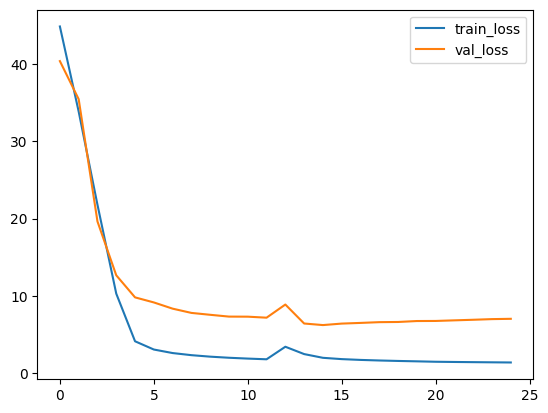

In [9]:
plt.plot(train_loss_history, label='train_loss')
plt.plot(val_loss_history, label='val_loss')

plt.legend()

In [10]:
print(dict(zip(['batch_time', 'loss', 'metric'], [round(e, 6) for e in validate_model(teacher_model, val_loader, alphabet, device=device)])))

{'batch_time': 0.003063, 'loss': 14.042188, 'metric': 0.049073}


In [ ]:
print(dict(zip(['batch_time', 'loss', 'metric'], [round(e, 6) for e in validate_model(student_model, val_loader, alphabet, device=device)])))

{'batch_time': 0.002026, 'loss': 14.102808, 'metric': 0.057071}


In [ ]:
from google.colab import runtime

runtime.unassign()